In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_docs as tfdocs
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from utils import config

mpl.rcParams['figure.figsize'] = [30.0, 12.0]
HDFStore=pd.HDFStore

In [4]:
# loading data parameters
num_coefficients=int(config["coefficients"])
root_path=config["root_path"]
hw_results_path= config["hw_results_path"]

# training parameters
seed=int(config["seed"]) if "seed" in config.keys() else 42

dr=float(config["dropout"]) if "dropout" in config.keys() else 0.2
lr2=float(config["lr2"]) if "lr2" in config.keys() else 1e-3
lr1=float(config["lr1"]) if "lr1" in config.keys() else 1e-4
lr=float(config["lr"]) if "lr" in config.keys() else 8e-4

num_epochs=int(config["num_epochs"]) if "num_epochs" in config.keys() else 1000
num_features=int(config["features"]) if "features" in config.keys() else 4096
mini_batch_size=int(config["mini_batch_size"]) if "mini_batch_size" in config.keys() else 4

main_units=int(config["main_units"]) if "main_units" in config.keys() else 64
secondary_units=int(config["secondary_units"]) if "secondary_units" in config.keys() else 16
last_unit=int(config["last_unit"]) if "last_unit" in config.keys() else 8
lstm_units=int(config["lstm_units"]) if "lstm_units" in config.keys() else 64
num_classes=int(config["num_classes"]) if "num_classes" in config.keys() else 1


print_sample=False

In [6]:
#Load data from hdf5 file
rdo_root_path = path.join(root_path,hw_results_path)
h5file = path.join(rdo_root_path, "archimedean-")
h5filename = h5file + str(num_coefficients) + "-splits.h5"
print(h5filename)
hdf = HDFStore(h5filename)
hdf.keys()

/data/elekin/data/results/03-HANDWRITTING/archimedean-17-splits.h5


['/residues/train/features',
 '/residues/train/labels',
 '/residues/test/features',
 '/residues/test/labels']

In [7]:
#Load and scale timeseries between 0 and 1
x_train = hdf["/residues/train/features"].values.astype('float32')
y_train = hdf["/residues/train/labels"].values.astype('int8').reshape(-1,1)
x_test = hdf["/residues/test/features"].values.astype('float32')
y_test = hdf["/residues/test/labels"].values.astype('int8').reshape(-1,1)
hdf.close()

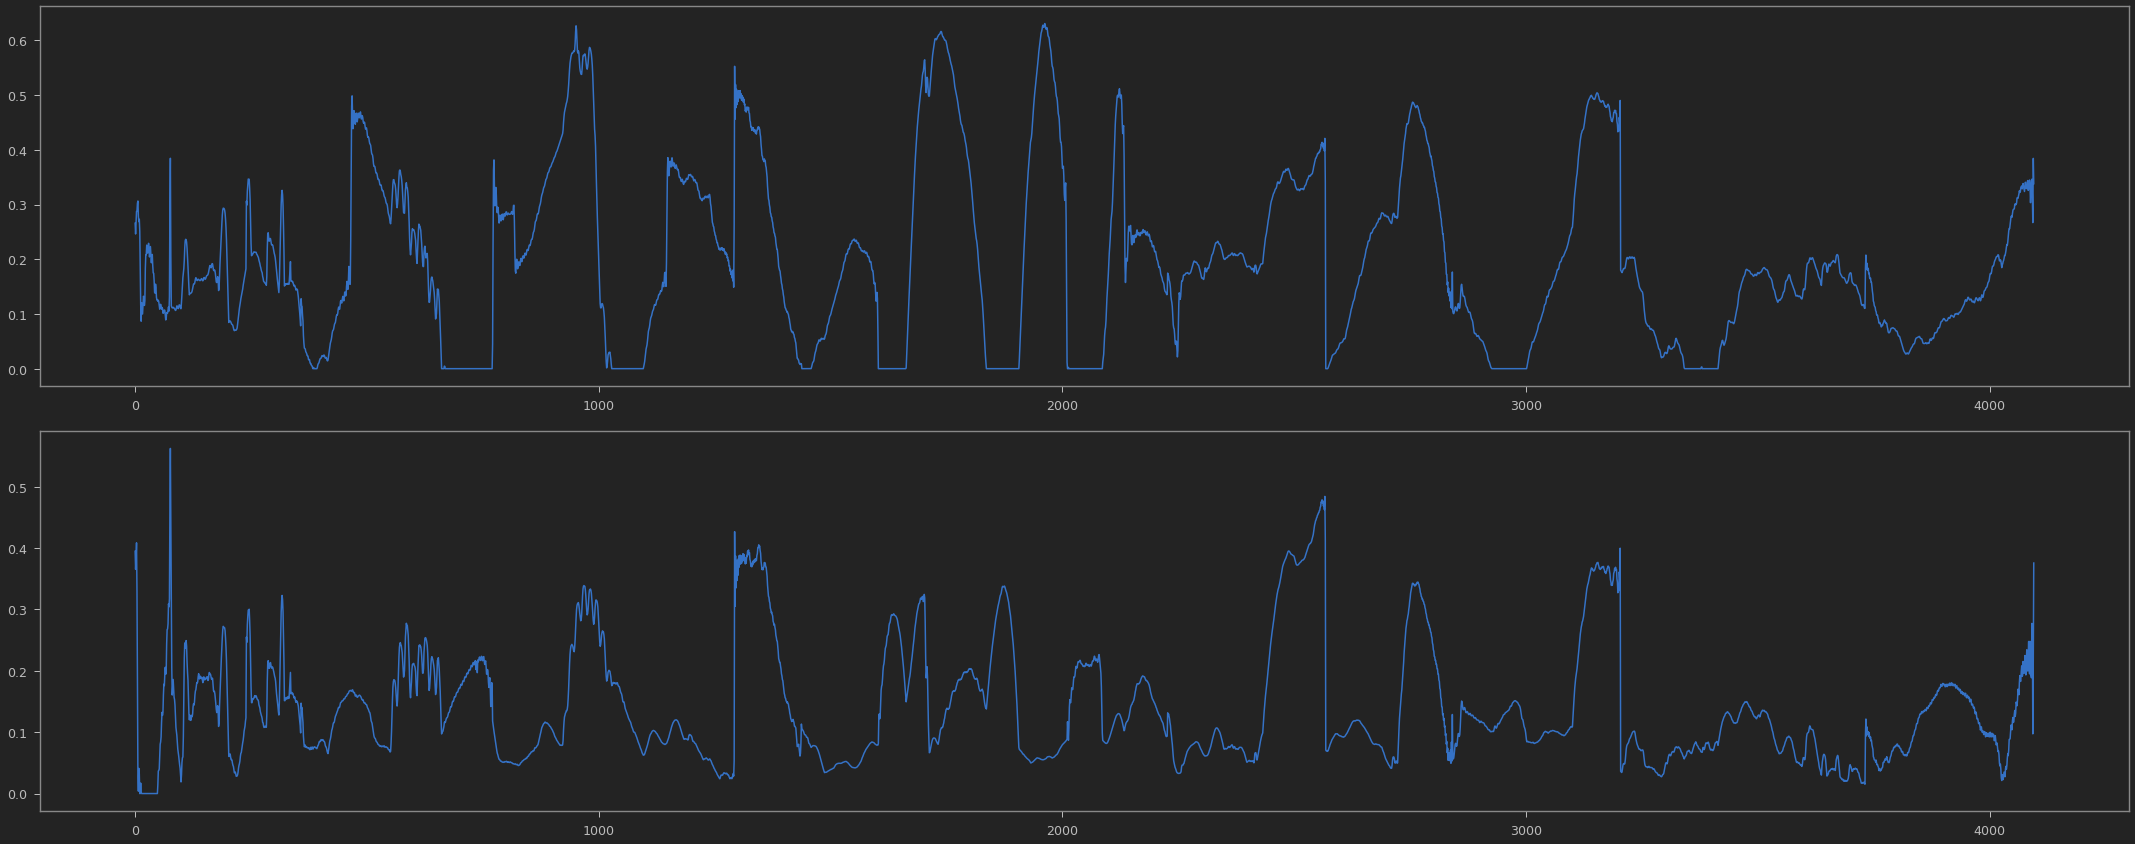

In [11]:
idx=5
fig, (ax1, ax2) =plt.subplots(nrows=2,ncols=1)
fig.tight_layout()
ax1.plot(x_train[idx])
ax2.plot(x_test[idx])

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(2).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(2).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

if print_sample:
    for feat, targ in test_dataset.take(10):
        print ('Features test: {}, Target: {}'.format(feat, targ))

    for feat, targ in test_dataset.take(10):
        print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))
test_dataset

9 train batches and 5 test batches of 4 mini batch size and 2 steps per epoch


<CacheDataset shapes: ((None, 4096), (None, 1)), types: (tf.float32, tf.int8)>

## CNN

In [13]:
# #Early stop configuration
earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=1e-3,
  patience=200)

training_earlystop_callback = EarlyStopping(
  monitor='accuracy', min_delta=1e-4,
  patience=200)

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        earlystop_callback,
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-5),
        #tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, train_dataset, test_dataset, name, optimizer=None, max_epochs=1000):
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(name),
                        verbose=0, shuffle=True)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [10]:
size_histories = {}

In [14]:
lstm_units=24
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features]),
    tf.keras.layers.Conv1D(filters=5, kernel_size=3,
                       activation=tf.nn.relu),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
#                         kernel_regularizer=regularizers.l2(lr2)
#                         ),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])

size_histories['cnn/conv1d'] = compile_and_fit(cnn,
                                               train_dataset,
                                               test_dataset,
                                               "cnn/conv1d", 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
                                               max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['cnn/conv1d'].history["accuracy"]))
print('test acc:', max(size_histories['cnn/conv1d'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 4096, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4094, 5)           20        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2047, 5)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2047, 5)           20        
_________________________________________________________________
dense (Dense)                (None, 2047, 64)          384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2047, 64)          256       
_________________________________________________________________
dense_1 (Dense)              (None, 2047, 64)          4

NameError: name 'size_histories' is not defined

In [ ]:
plotter_loss = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter_acc = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)

In [ ]:
plotter_loss.plot(size_histories)
plt.ylim([0., 5.])

In [ ]:
plotter_acc.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0., 0.9])
plt.xlabel("Epochs [Log Scale]")

In [ ]:
plotter_loss.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0., 2.9])
plt.xlabel("Epochs [Log Scale]")